# データ読み込み

In [4]:
import pandas as pd
import numpy as np

In [13]:
df = pd.read_csv('/volume_dir/boatrace/df_label_encode.csv')

# 前処理

In [3]:
df.columns

Index(['race_code', 'date', 'race_date', 'place', 'round', 'order', 'number',
       'display', 'in', 'st_time', 'race_time', 'type', 'weather', 'wind',
       'wind_strong', 'wave', 'title', 'race_name', 'position', 'name', 'age',
       'area', 'weight', 'class', 'win_p', 'win_p_2', 'a_win_p', 'a_win_p_2',
       'motor', 'motor_p_2', 'boat', 'boat_p_2', 'day', 'day_of_year',
       'day_of_year_cos', 'day_of_year_sin'],
      dtype='object')

In [14]:
#　使わない変数を消去
drop_name = ['race_code','race_date','number','title', 'race_name','in']
df = df.drop(drop_name, axis=1)

# 関数

In [15]:
# 時系列で整列したもの
def split_data(df,test_size):
    sorted_id_list = df.sort_values('race_date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train,test

def order_reset(df):
    # 4位以下の着順を4で統一
    clip_order = lambda x: x if x<4 else 4
    df['order'] = df['order'].map(clip_order)
    
    return df

# ここからが推論編

## ロジスティック回帰

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df.drop(['order'], axis=1)
y = df['order']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1038420, 29)
(259606, 29)
(1038420,)
(259606,)


In [22]:
y_train.value_counts()

2    228814
1    228805
3    228757
4    228214
5     63705
6     60125
Name: order, dtype: int64

In [27]:
from imblearn.under_sampling import RandomUnderSampler
order_1 = y_train.value_counts()[1]
order_2 = y_train.value_counts()[2]
order_3 = y_train.value_counts()[3]
strategy = {1:order_1,2:order_2,3:order_3,4:order_1}
rus = RandomUnderSampler(sampling_strategy = strategy,random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

In [30]:
pd.Series(y_train_rus).value_counts()

2    228814
1    228805
4    228805
3    228757
Name: order, dtype: int64

In [31]:
model = LogisticRegression()
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [32]:
print(model.score(X_train,y_train),model.score(X_test, y_test))

0.40632499374049036 0.40700137901281175


In [34]:
y_pred = model.predict(X_test)

In [35]:
pred_df = pd.DataFrame({'pred':y_pred,'actual':y_test})

In [41]:
pred_df[pred_df['pred']==4]['actual'].value_counts()

4    68199
3    35821
2    29338
1    20083
Name: actual, dtype: int64

In [40]:
len(pred_df[pred_df['pred']==4])

153441

<AxesSubplot:>

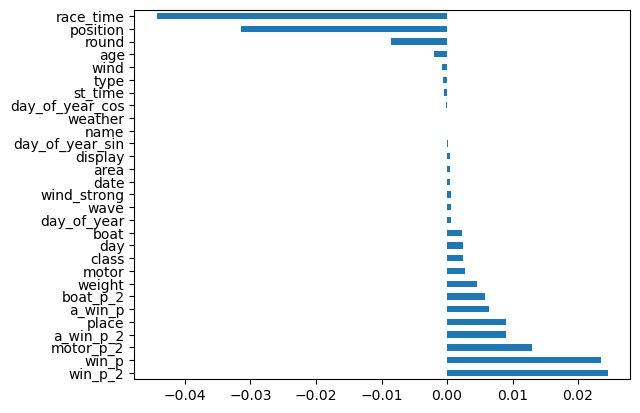

In [42]:
pd.Series(model.coef_[0],index=X.columns).sort_values(ascending=False).plot(kind='barh')

## ランダムフォレスト

In [105]:
df = pd.read_csv('/volume_dir/boatrace/df_label_encode.csv')

In [132]:
clip_order = lambda x: 1 if x<4 else 0
df['order'] = df['order'].map(clip_order)

In [133]:
df['race_date'] = pd.to_datetime(df['race_date'])

In [134]:
#　使わない変数を消去
drop_name = ['race_code','number','title', 'race_name','in','race_time']
df = df.drop(drop_name, axis=1)

KeyError: "['race_code' 'number' 'title' 'race_name' 'in' 'race_time'] not found in axis"

In [135]:
def split_data(df,test_size):
    sorted_id_list = df.sort_values('race_date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train,test

In [136]:
train,test = split_data(df,0.3)

In [137]:
X_train = train.drop(['order','race_date'], axis=1)
y_train = train['order']
X_test = test.drop(['order','race_date'], axis=1)
y_test = test['order']

In [138]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(908618, 28)
(389408, 28)
(908618,)
(389408,)


In [149]:
df['order'].value_counts()[0]

440056

In [140]:
from imblearn.under_sampling import RandomUnderSampler
order_1 = train['order'].value_counts()[1]
order_2 = train['order'].value_counts()[2]
order_3 = train['order'].value_counts()[3]
strategy = {1:order_1,2:order_2,3:order_3,4:order_1}
rus = RandomUnderSampler(sampling_strategy = strategy,random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

KeyError: 2

In [150]:
from imblearn.under_sampling import RandomUnderSampler
order_1 = train['order'].value_counts()[0]
strategy = {0:order_1,1:order_1}
rus = RandomUnderSampler(sampling_strategy = strategy,random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

In [156]:
from sklearn.metrics import roc_auc_score,roc_curve
params = {
    'min_samples_split': 300,
    'random_state': 42,
}
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred_train = rf.predict_proba(X_train)[:,1]
y_pred = rf.predict_proba(X_test)[:,1]

In [157]:
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

0.8093457625971561
0.7680912760642773


In [158]:
importances = pd.DataFrame({'features':X_train.columns, 'importance':rf.feature_importances_})
importances.sort_values('importance',ascending=False)


,features,importance
10,position,0.291610
16,win_p,0.106460
1,place,0.094138
17,win_p_2,0.084047
5,type,0.065436
4,st_time,0.064179
15,class,0.046824
18,a_win_p,0.038145
2,round,0.028483
19,a_win_p_2,0.019969


In [169]:
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

In [170]:
df_pred = pd.DataFrame({'target':y_test,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'target':y_test, 'target0_prob':y_pred_prob[:,0], 'target1_prob':y_pred_prob[:,1]})
display(df_pred_prob)

,target,target_pred
1195663,1,1
1195888,1,1
1195887,1,1
1195886,0,1
1195885,1,1
...,...,...
1127112,1,1
1127111,1,0
1127110,1,1
1127138,0,0


,target,target0_prob,target1_prob
1195663,1,0.303534,0.696466
1195888,1,0.200477,0.799523
1195887,1,0.101944,0.898056
1195886,0,0.364534,0.635466
1195885,1,0.155818,0.844182
...,...,...,...
1127112,1,0.359658,0.640342
1127111,1,0.576102,0.423898
1127110,1,0.002887,0.997113
1127138,0,0.539763,0.460237


In [172]:
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
# モデル評価
# acc : 正答率
acc = accuracy_score(y_test,y_pred)
print('Acc :', acc)

# logloss 
logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
print('logloss :', logloss)

# AUC 
auc = roc_auc_score(y_test,y_pred_prob[:,1]) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
print('AUC :', auc) 

Acc : 0.7348513641219492
logloss : 0.5094112920872816
AUC : 0.7810496678954698


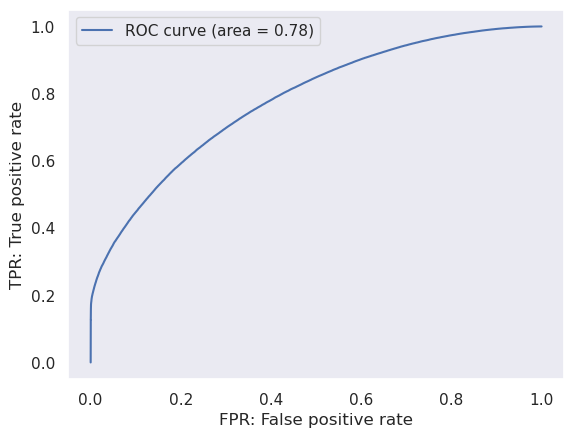

In [174]:
import pandas as pd # 基本ライブラリ
import numpy as np # 基本ライブラリ
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用
# ROC曲線の描画
# cf : https://tips-memo.com/python-roc
from sklearn import metrics
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

In [175]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 2値分類 
        'metric': {'binary_error'}, # 評価指標 : 誤り率(= 1-正答率) 
        #他には 'binary_logloss','auc'など
        'learning_rate': 0.1,
        'num_leaves': 23,
        'min_data_in_leaf': 1,
        'num_iteration': 1000, #1000回学習
        'verbose': 0
}

# モデルの学習
model = lgb.train(params, # パラメータ
            train_set=lgb_train, # トレーニングデータの指定
            valid_sets=lgb_eval, # 検証データの指定
            early_stopping_rounds=100 # 100回ごとに検証精度の改善を検討　→ 精度が改善しないなら学習を終了(過学習に陥るのを防ぐ)
               )

# テストデータの予測 (クラス1の予測確率(クラス1である確率)を返す)
y_pred_prob = model.predict(X_test)
# テストデータの予測
y_pred = np.where(y_pred_prob < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_error: 0.33375
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_error: 0.33375
[3]	valid_0's binary_error: 0.33375
[4]	valid_0's binary_error: 0.326688
[5]	valid_0's binary_error: 0.324814
[6]	valid_0's binary_error: 0.310872
[7]	valid_0's binary_error: 0.30494
[8]	valid_0's binary_error: 0.301766
[9]	valid_0's binary_error: 0.29673
[10]	valid_0's binary_error: 0.292385
[11]	valid_0's binary_error: 0.289927
[12]	valid_0's binary_error: 0.287269
[13]	valid_0's binary_error: 0.285138
[14]	valid_0's binary_error: 0.282252
[15]	valid_0's binary_error: 0.280605
[16]	valid_0's binary_error: 0.278816
[17]	valid_0's binary_error: 0.277709
[18]	valid_0's binary_error: 0.276679
[19]	valid_0's binary_error: 0.276263
[20]	valid_0's binary_error: 0.275362
[21]	valid_0's binary_error

In [176]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'target':y_test, 'target0_prob':1-y_pred_prob, 'target1_prob':y_pred_prob})
display(df_pred_prob)

,target,target_pred
1195663,1,1
1195888,1,1
1195887,1,1
1195886,0,1
1195885,1,1
...,...,...
1127112,1,1
1127111,1,0
1127110,1,1
1127138,0,0


,target,target0_prob,target1_prob
1195663,1,0.274940,0.725060
1195888,1,0.209755,0.790245
1195887,1,0.097386,0.902614
1195886,0,0.349713,0.650287
1195885,1,0.156439,0.843561
...,...,...,...
1127112,1,0.347682,0.652318
1127111,1,0.555648,0.444352
1127110,1,0.001924,0.998076
1127138,0,0.509605,0.490395


In [177]:
acc = accuracy_score(y_test,y_pred)
print('Acc :', acc)

# logloss 
logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
print('logloss :', logloss)

# AUC 
auc = roc_auc_score(y_test,y_pred_prob) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
print('AUC :', auc) 

Acc : 0.7349284041416715
logloss : 0.5093794628113785
AUC : 0.7810608217989381


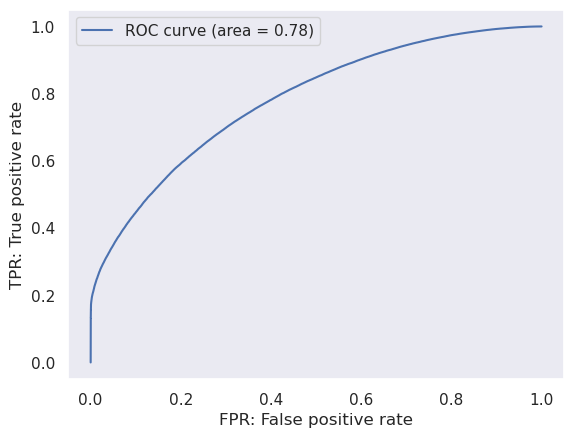

In [178]:
# ROC曲線の描画
# cf : https://tips-memo.com/python-roc
from sklearn import metrics
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

In [1]:
test_size = 0.3

In [2]:
sort = 10000

In [3]:
sort*(1-0.3)

7000.0